# EDA

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import pandas as pd 
import re
import string
import seaborn as sns

In [2]:
df_anime = pd.read_csv("../data/animes.csv")
df_profile = pd.read_csv("../data/profiles.csv")
df_review = pd.read_csv("../data/reviews.csv")

## Some Helper Functions

In [3]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import math

In [4]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove '\r\n' patterns
    text = re.sub(r'\r\n', '', text)

    # Remove '[Written by MAL Rewrite]' at the end of the text
    text = re.sub(r'\[written by mal rewrite\]$', '', text)

    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the words back into a single string
    preprocessed_text = ' '.join(words)

    return preprocessed_text


In [5]:
def preprocess_text_2(text):
    # Find the start and end index of the pattern
    start_index = text.find("more pics")
    end_index = text.find("Enjoyment") + len("Enjoyment")
    
    # Remove the pattern from the text
    text = text[:start_index] + text[end_index:]
    
    # Remove extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text).strip()

    # Lowercase the text
    text = text.lower()

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove the last number from the pattern
    pattern = re.compile(r'\b\d+\b')
    tokens = [token for token in tokens if not pattern.match(token)]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a single string
    processed_text = ' '.join(tokens)

    return processed_text

In [6]:
# Distribution graphs (histogram/bar graph) of column data
# Helper function taken from online

# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow  # Use integer division
    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if not np.issubdtype(type(columnDf.iloc[0]), np.number):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

In [7]:
# Correlation matrix
# Function taken from oinline
def plotCorrelationMatrix(df, graphWidth):

    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()

    fig, ax = plt.subplots(figsize=(graphWidth, graphWidth))
    cax = ax.matshow(corr, cmap='coolwarm')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar(cax)

    # Add annotations to each cell
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            text = ax.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', color='black')

    plt.title('Correlation Matrix', fontsize=15)
    plt.show()


In [8]:
# Scatter and density plots
# Taken from online
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular

    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10:
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

## Cleaning df's based on last notebook and running EDA after

### Cleaning main anime db

In [9]:
df_anime.drop_duplicates(subset = "uid", keep = 'first', inplace = True)
df_anime.drop_duplicates(subset = "title", keep = 'first', inplace = True)
df_anime['synopsis'].fillna(value = 'blank', inplace = True)
df_anime['episodes'].fillna(value = -1, inplace = True)
df_anime['ranked'].fillna(value = -1, inplace = True)
df_anime['score'].fillna(value = -1, inplace = True)
df_anime['img_url'].fillna(value = 'blank', inplace = True)

### Cleaning profile db

In [10]:
df_profile.drop_duplicates(subset = "profile", keep = 'first', inplace = True)
df_profile['gender'].fillna(value = 'unavailable', inplace = True)
df_profile['birthday'].fillna(value = 'unavailable', inplace = True)

### Running main text preprocesser:
- the original db_name will have the whole dataset available. Any subset dbs made will derive from these


In [14]:
df_review['text_preprocessed'] = df_review['text'].apply(preprocess_text_2)


In [15]:
df_anime['synopsis_processed'] = df_anime['synopsis'].apply(preprocess_text)

## Running some visualizations on df_anime

In [16]:
nRow, nCol = df_anime.shape
all_Cols = df_anime.columns
print(f'There are {nRow} rows and {nCol} columns')
print(f'All the columns are: {all_Cols}')

There are 16214 rows and 13 columns
All the columns are: Index(['uid', 'title', 'synopsis', 'genre', 'aired', 'episodes', 'members',
       'popularity', 'ranked', 'score', 'img_url', 'link',
       'synopsis_processed'],
      dtype='object')


In [17]:
#branching off from main df_anime
df_anime_2 = df_anime.drop(columns = ['img_url', 'link', 'synopsis'], axis = 1)

In [18]:
plotPerColumnDistribution(df_anime_2, 10, 5)

<Figure size 2400x0 with 0 Axes>

C:\Users\samue\AppData\Local\Temp\ipykernel_22344\3238902411.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


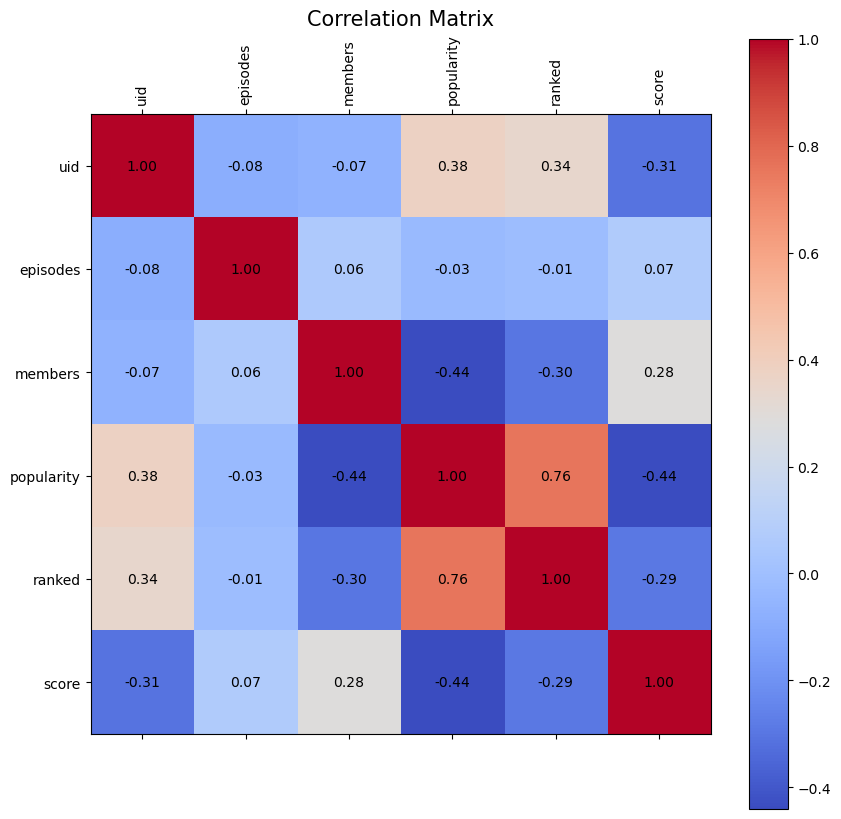

In [19]:
plotCorrelationMatrix(df_anime_2, 10)

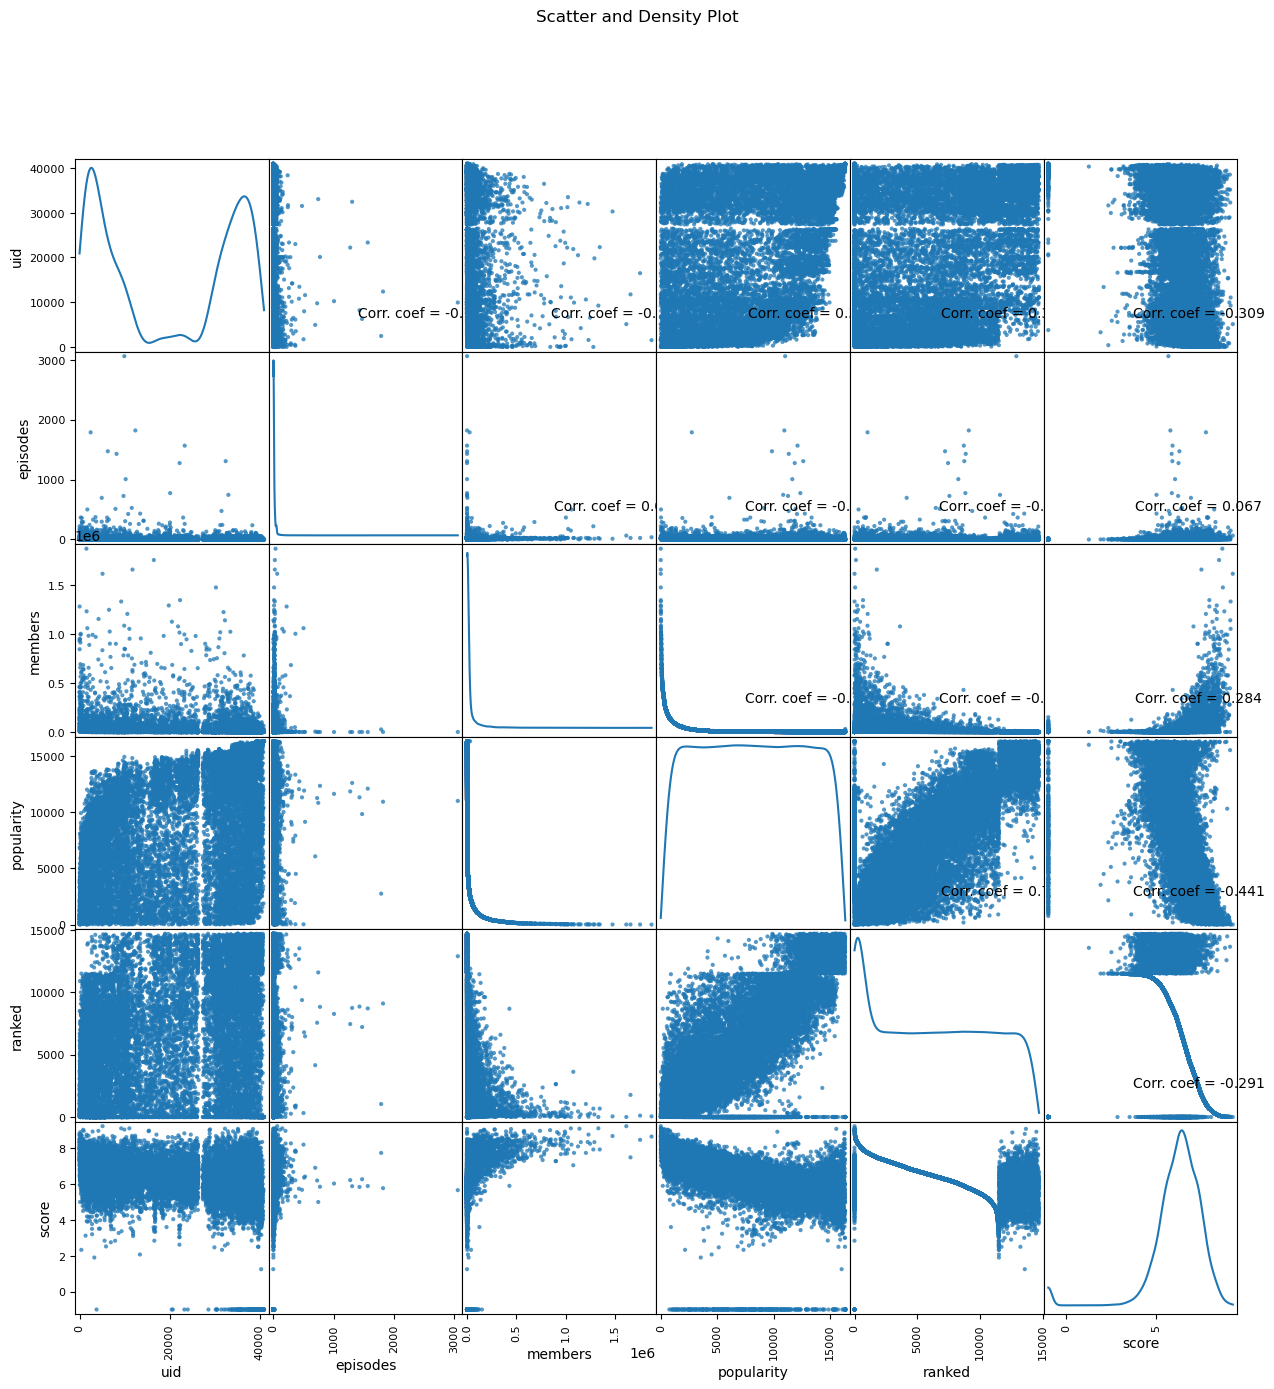

In [20]:
plotScatterMatrix(df_anime_2, 15, 10)

## Running visual on df_prolfile

In [21]:
nRow, nCol = df_profile.shape
all_cols = df_profile.columns
print(f'There are {nRow} rows and {nCol} columns')
print(f'All the columns are: {all_cols}')

There are 47885 rows and 5 columns
All the columns are: Index(['profile', 'gender', 'birthday', 'favorites_anime', 'link'], dtype='object')


In [22]:
#branching off from main df_profile
df_profile_2 = df_profile.drop(columns = ['link'], axis = 1)

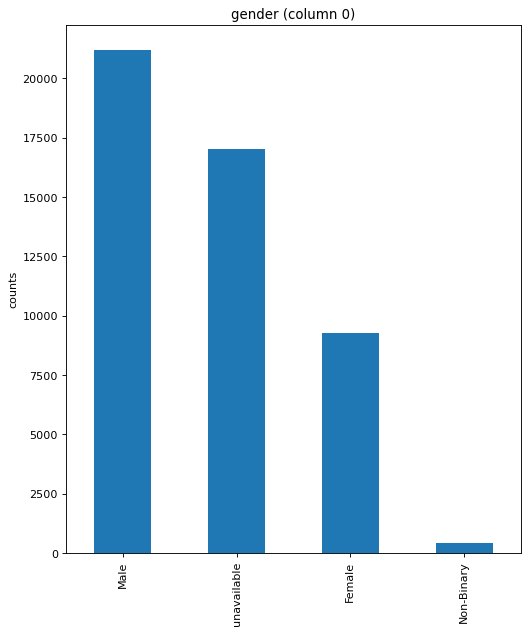

In [23]:
plotPerColumnDistribution(df_profile_2, 10, 5)

### Visaual for review

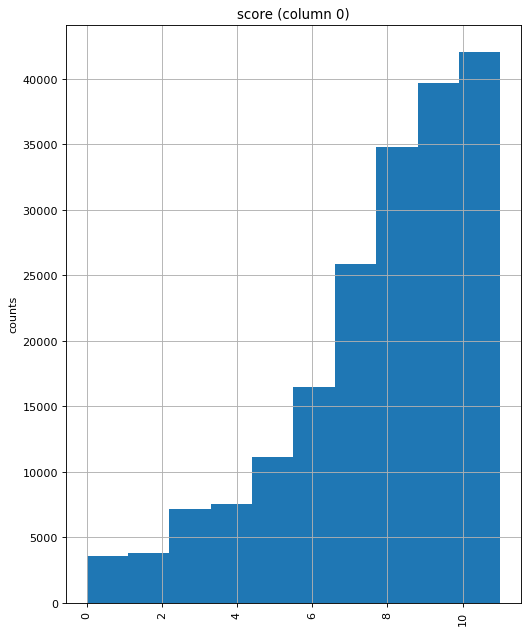

In [24]:
plotPerColumnDistribution(df_review, 10, 5)

C:\Users\samue\AppData\Local\Temp\ipykernel_22344\3238902411.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


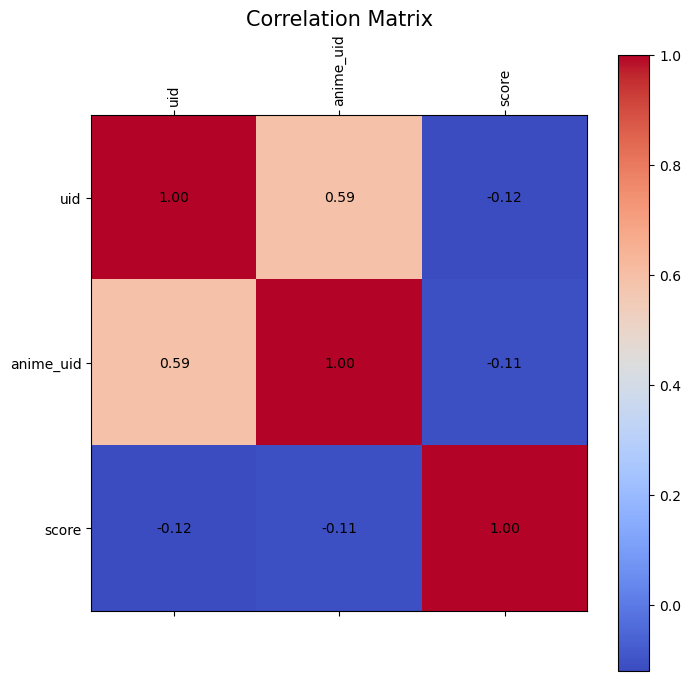

In [25]:
plotCorrelationMatrix(df_review, 8)

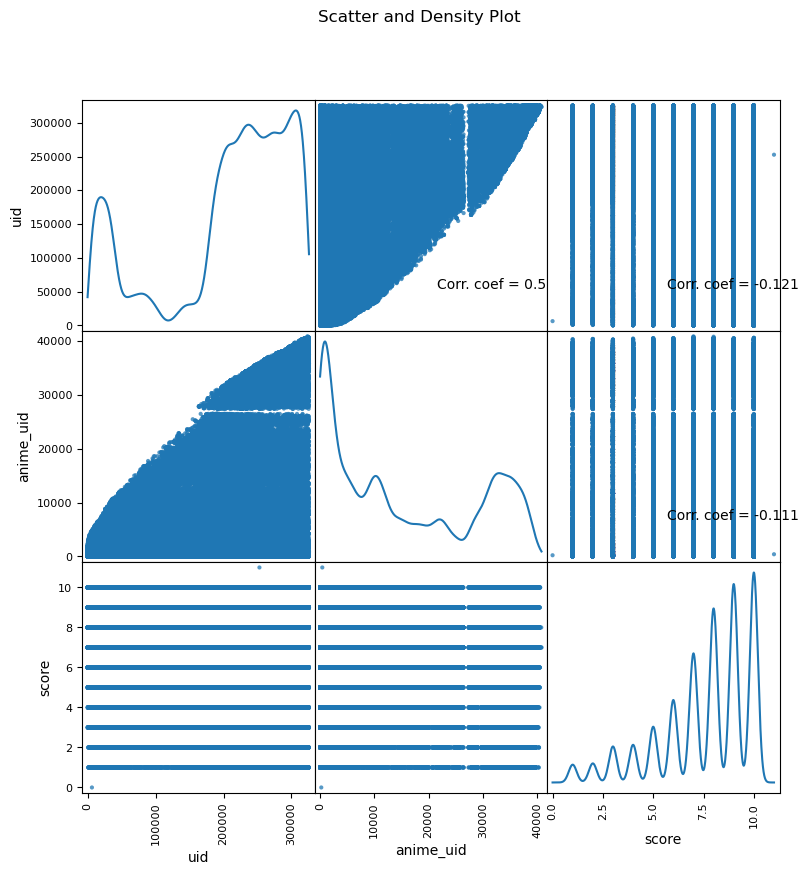

In [26]:
plotScatterMatrix(df_review, 9, 10)

## EDA on merged df

In [71]:
#explode the col
#df_profile_exploded = df_profile_2.explode('favorites_anime')
df_profile_exploded = df_profile_2
# Clean the 'favorites_anime' column by removing square brackets and quotes
df_profile_exploded['favorites_anime'] = df_profile_exploded['favorites_anime'].str.replace(r"[\[\]']", '', regex=True)

# Create a new DataFrame with each element of 'favorites_anime' in a separate row
df_profile_exploded = df_profile_exploded.assign(favorites_anime=df_profile_exploded['favorites_anime'].str.split(','))

df_profile_exploded = df_profile_exploded.explode('favorites_anime')

# Filter out empty values in 'favorites_anime' column
df_profile_exploded = df_profile_exploded[df_profile_exploded['favorites_anime'] != '']

# Convert 'favorites_anime' column to integers
df_profile_exploded['favorites_anime'] = df_profile_exploded['favorites_anime'].astype(int)

# Convert 'uid' column in df_anime to 'object' data type
df_anime_2['uid'] = df_anime_2['uid'].astype('object')

#perform merge
merged_df = pd.merge(df_anime_2, df_profile_exploded, left_on='uid', right_on='favorites_anime', how='inner')

In [31]:
#legacy merger
# Explode the col
#df_profile_exploded = df_profile_2.explode('favorites_anime')

# Clean the 'favorites_anime' column by removing square brackets and quotes
#df_profile_exploded['favorites_anime'] = df_profile_exploded['favorites_anime'].str.replace(r"[\[\]']", '', regex=True)

# Convert 'favorites_anime' column to integers
#df_profile_exploded['favorites_anime'] = df_profile_exploded['favorites_anime'].astype(int)

# Convert 'uid' column in df_anime to 'object' data type
#df_anime_2['uid'] = df_anime_2['uid'].astype('object')

# Perform merge
#merged_df = pd.merge(df_anime_2, df_profile_exploded, left_on='uid', right_on='favorites_anime', how='inner')

In [72]:
print(f"len of df_profiles: {len(df_profile_2)} and len of df_profiles_exploded: {df_profile_exploded.size}")

len of df_profiles: 47885 and len of df_profiles_exploded: 866780


In [75]:
merged_df.size

3028158

## Using SNS for some more EDA

In [34]:
noneg_score_merged = merged_df[merged_df['score'] != -1]

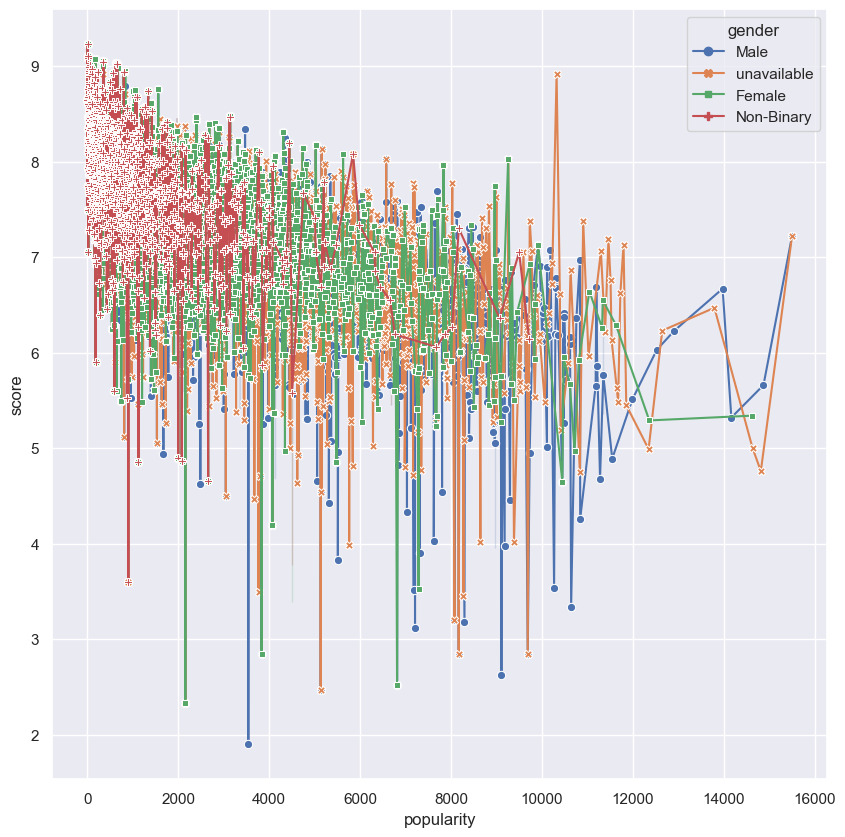

In [35]:
# Setting the standard seaborn background
sns.set()
#Setting the figure size(Lineplot is actually an Axes Matplotlib Object that's why we use matplotlib library for setting figure size)
plt.rcParams['figure.figsize']=(10,10)
#95% CI is default in the lineplot
sns.lineplot(y='score',x='popularity', data=noneg_score_merged, hue='gender',style='gender',markers=True,dashes=False)
plt.show()

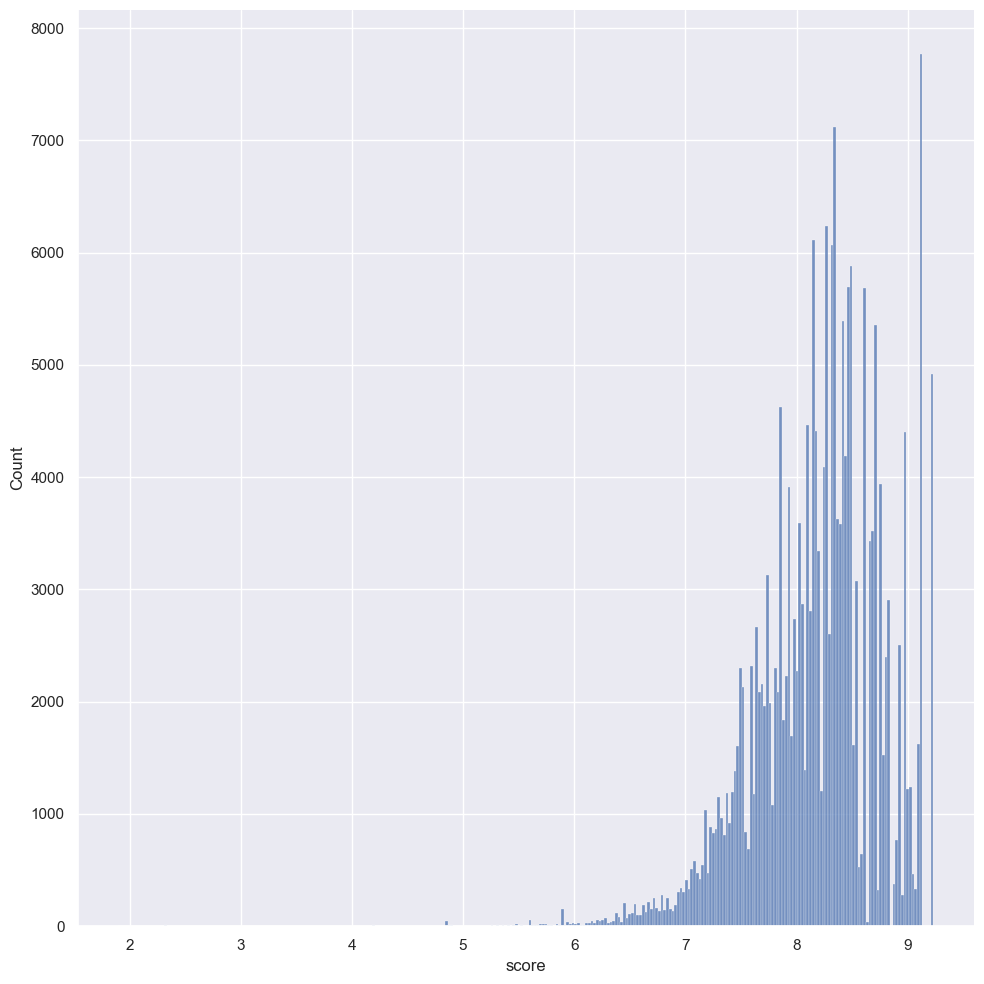

In [36]:
sns.displot(data=noneg_score_merged,x='score',kind='hist',height=10)
plt.show()

## Will try to merge again by reducing dimensions

In [37]:
merged_df_reduc = merged_df.drop(columns=["favorites_anime"])
df_review_reduc = df_review.drop(columns=["uid", "text", "link"])

In [38]:
merged_df_reduc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216297 entries, 0 to 216296
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   uid                 216297 non-null  object 
 1   title               216297 non-null  object 
 2   genre               216297 non-null  object 
 3   aired               216297 non-null  object 
 4   episodes            216297 non-null  float64
 5   members             216297 non-null  int64  
 6   popularity          216297 non-null  int64  
 7   ranked              216297 non-null  float64
 8   score               216297 non-null  float64
 9   synopsis_processed  216297 non-null  object 
 10  profile             216297 non-null  object 
 11  gender              216297 non-null  object 
 12  birthday            216297 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 23.1+ MB


In [39]:
df_review_reduc.rename(columns={"score":"review_score", "anime_uid":"uid", "scores":"review_score_indepth"}, inplace = True)

In [40]:
merged_rev_df = pd.merge(merged_df_reduc, df_review_reduc, on=['uid', 'profile'])

In [41]:
merged_rev_df.head(1)

,uid,title,genre,aired,episodes,members,popularity,ranked,score,synopsis_processed,profile,gender,birthday,review_score,review_score_indepth,text_preprocessed
0,28891,Haikyuu!! Second Season,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,"following participation inter-high , karasuno ...",Drevorn,Male,"Mar 20, 1995",10,"{'Overall': '10', 'Story': '10', 'Animation': ...",2nd season haikyuu ! ! pick right 1st season e...


In [42]:
print(f"len of df_review_reduc: {len(df_review_reduc)} and len of merged_df: {len(merged_df_reduc)} and len of super combined: {len(merged_rev_df)}")

len of df_review_reduc: 192112 and len of merged_df: 216297 and len of super combined: 27299


In [43]:
test_type = merged_rev_df['genre'].iloc[0:1]
test_type[0]

"['Comedy', 'Sports', 'Drama', 'School', 'Shounen']"

In [44]:
type(test_type[0])

str

In [45]:
#the genres are a string, not list. Will convert to list
import ast
def convert_to_list(genre_string):
    return ast.literal_eval(genre_string)

In [46]:
merged_rev_df['genre'] = merged_rev_df['genre'].apply(convert_to_list)

In [47]:
merged_rev_df.head(5)

,uid,title,genre,aired,episodes,members,popularity,ranked,score,synopsis_processed,profile,gender,birthday,review_score,review_score_indepth,text_preprocessed
0,28891,Haikyuu!! Second Season,"[Comedy, Sports, Drama, School, Shounen]","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,"following participation inter-high , karasuno ...",Drevorn,Male,"Mar 20, 1995",10,"{'Overall': '10', 'Story': '10', 'Animation': ...",2nd season haikyuu ! ! pick right 1st season e...
1,28891,Haikyuu!! Second Season,"[Comedy, Sports, Drama, School, Shounen]","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,"following participation inter-high , karasuno ...",Drevorn,Male,"Mar 20, 1995",10,"{'Overall': '10', 'Story': '10', 'Animation': ...",2nd season haikyuu ! ! pick right 1st season e...
2,28891,Haikyuu!! Second Season,"[Comedy, Sports, Drama, School, Shounen]","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,"following participation inter-high , karasuno ...",NICK1994,Male,"Nov 13, 1994",10,"{'Overall': '10', 'Story': '10', 'Animation': ...",intense ! ! ! ! ! ! word describes plot season...
3,28891,Haikyuu!! Second Season,"[Comedy, Sports, Drama, School, Shounen]","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,"following participation inter-high , karasuno ...",NICK1994,Male,"Nov 13, 1994",10,"{'Overall': '10', 'Story': '10', 'Animation': ...",intense ! ! ! ! ! ! word describes plot season...
4,28891,Haikyuu!! Second Season,"[Comedy, Sports, Drama, School, Shounen]","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,"following participation inter-high , karasuno ...",RuiAizawa,Female,"Aug 24, 1997",10,"{'Overall': '10', 'Story': '10', 'Animation': ...","honestly , kind anime absolutely interest voll..."


In [48]:
df_anime.head(1)

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link,synopsis_processed
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...,"following participation inter-high , karasuno ..."


In [49]:
df_profile.head(1)

,profile,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,"Oct 2, 1994","['33352', '25013', '5530', '33674', '1482', '2...",https://myanimelist.net/profile/DesolatePsyche


In [50]:
merged_df.head(1)

,uid,title,genre,aired,episodes,members,popularity,ranked,score,synopsis_processed,profile,gender,birthday,favorites_anime
0,28891,Haikyuu!! Second Season,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,"following participation inter-high , karasuno ...",kyojin13,Male,Oct 6,28891


In [51]:
df_anime_export = df_anime.drop(columns=["img_url","link"])

In [52]:
df_profile_export = df_profile.drop(columns = ["link"])

In [53]:
merged_df_export = merged_df
merged_rev_df_export = merged_rev_df
df_review_export = df_review_reduc

In [54]:
#exporting
#df_anime_export.to_csv('df_anime_export.csv')
#df_profile_export.to_csv('df_profile_export.csv')
#df_review_export.to_csv('df_review_export.csv')
#merged_df_export.to_csv('merged_df_export.csv')
#merged_rev_df_export.to_csv('merged_rev_df_export.csv')


In [1]:
df_anime.head(1)

NameError: name 'df_anime' is not defined

## a lil more sns eda

In [55]:
merged_rev_df.head(1)

,uid,title,genre,aired,episodes,members,popularity,ranked,score,synopsis_processed,profile,gender,birthday,review_score,review_score_indepth,text_preprocessed
0,28891,Haikyuu!! Second Season,"[Comedy, Sports, Drama, School, Shounen]","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,"following participation inter-high , karasuno ...",Drevorn,Male,"Mar 20, 1995",10,"{'Overall': '10', 'Story': '10', 'Animation': ...",2nd season haikyuu ! ! pick right 1st season e...


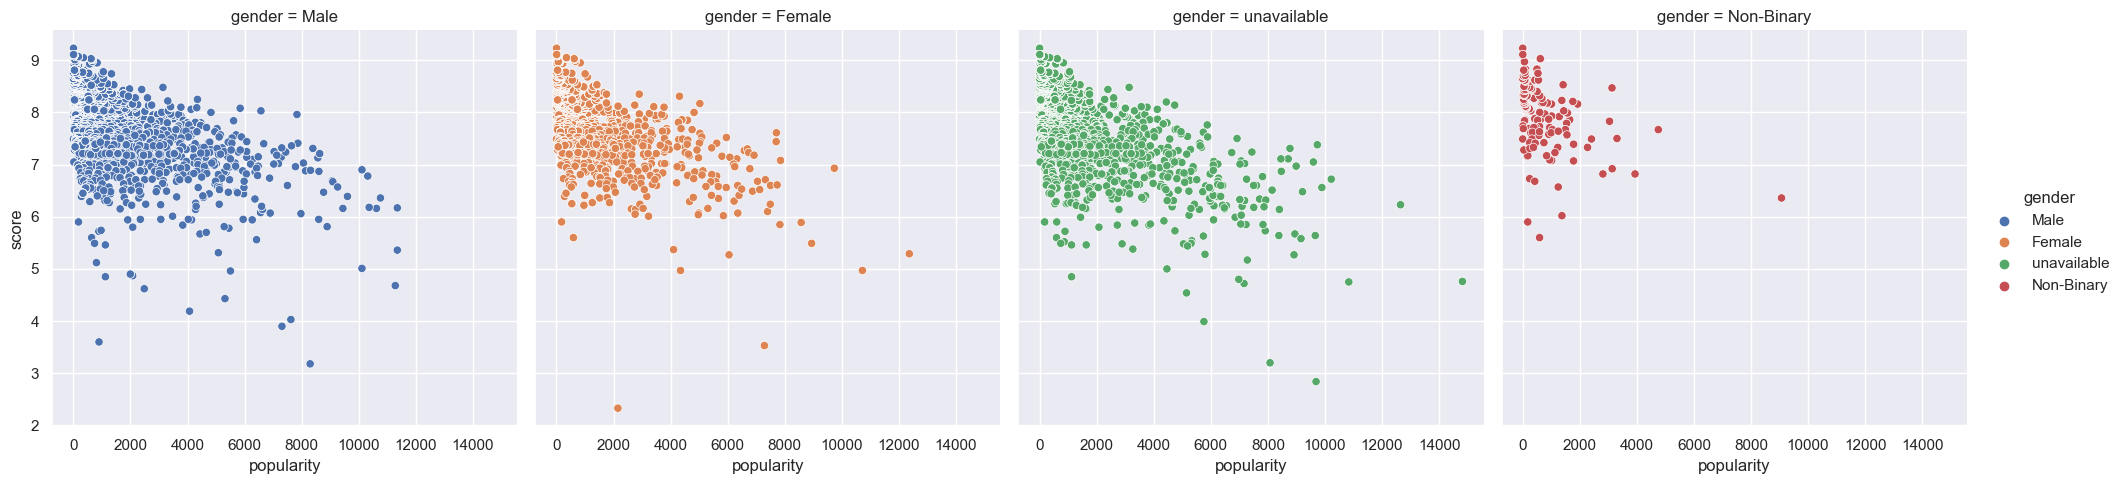

In [56]:
#A general relation plot of popularity(Scatterplot)

sns.relplot(y='score',x='popularity',data=merged_rev_df,col='gender',hue='gender')
plt.show()

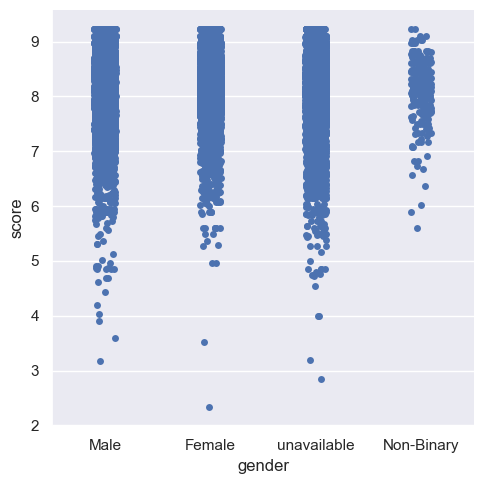

In [57]:
def plotkind(ydata,kind,**kwargs):
    return sns.catplot(x='gender',y=ydata,data=merged_rev_df,kind=kind,**kwargs)

plotkind('score','strip')
plt.show()

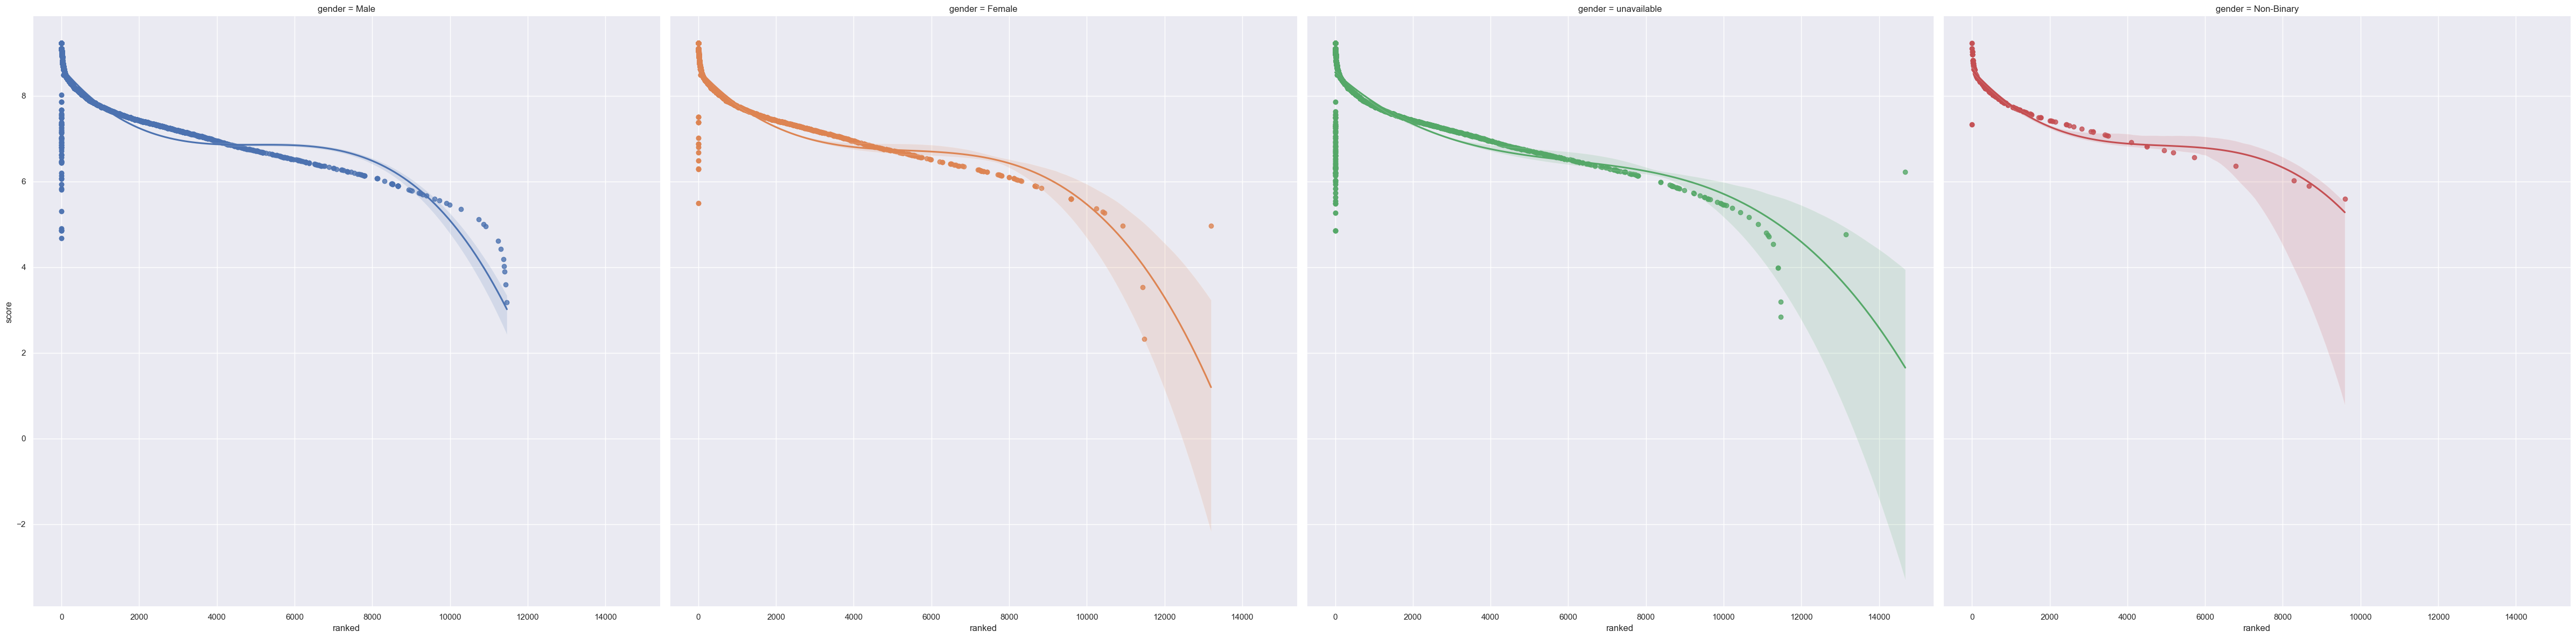

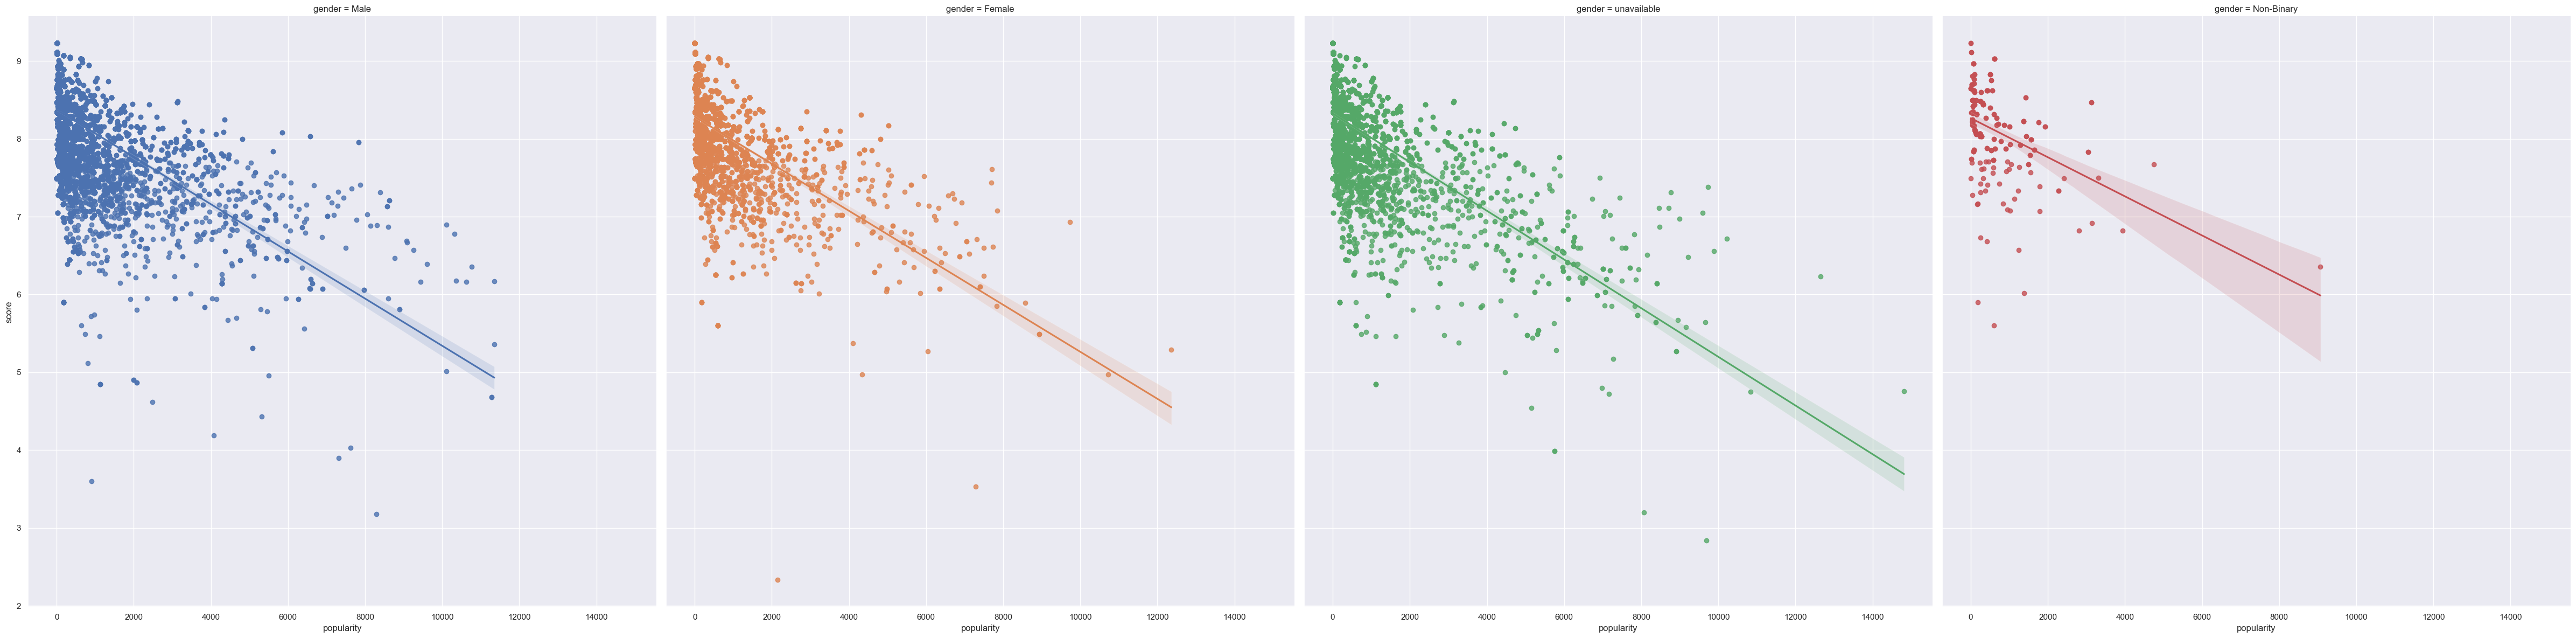

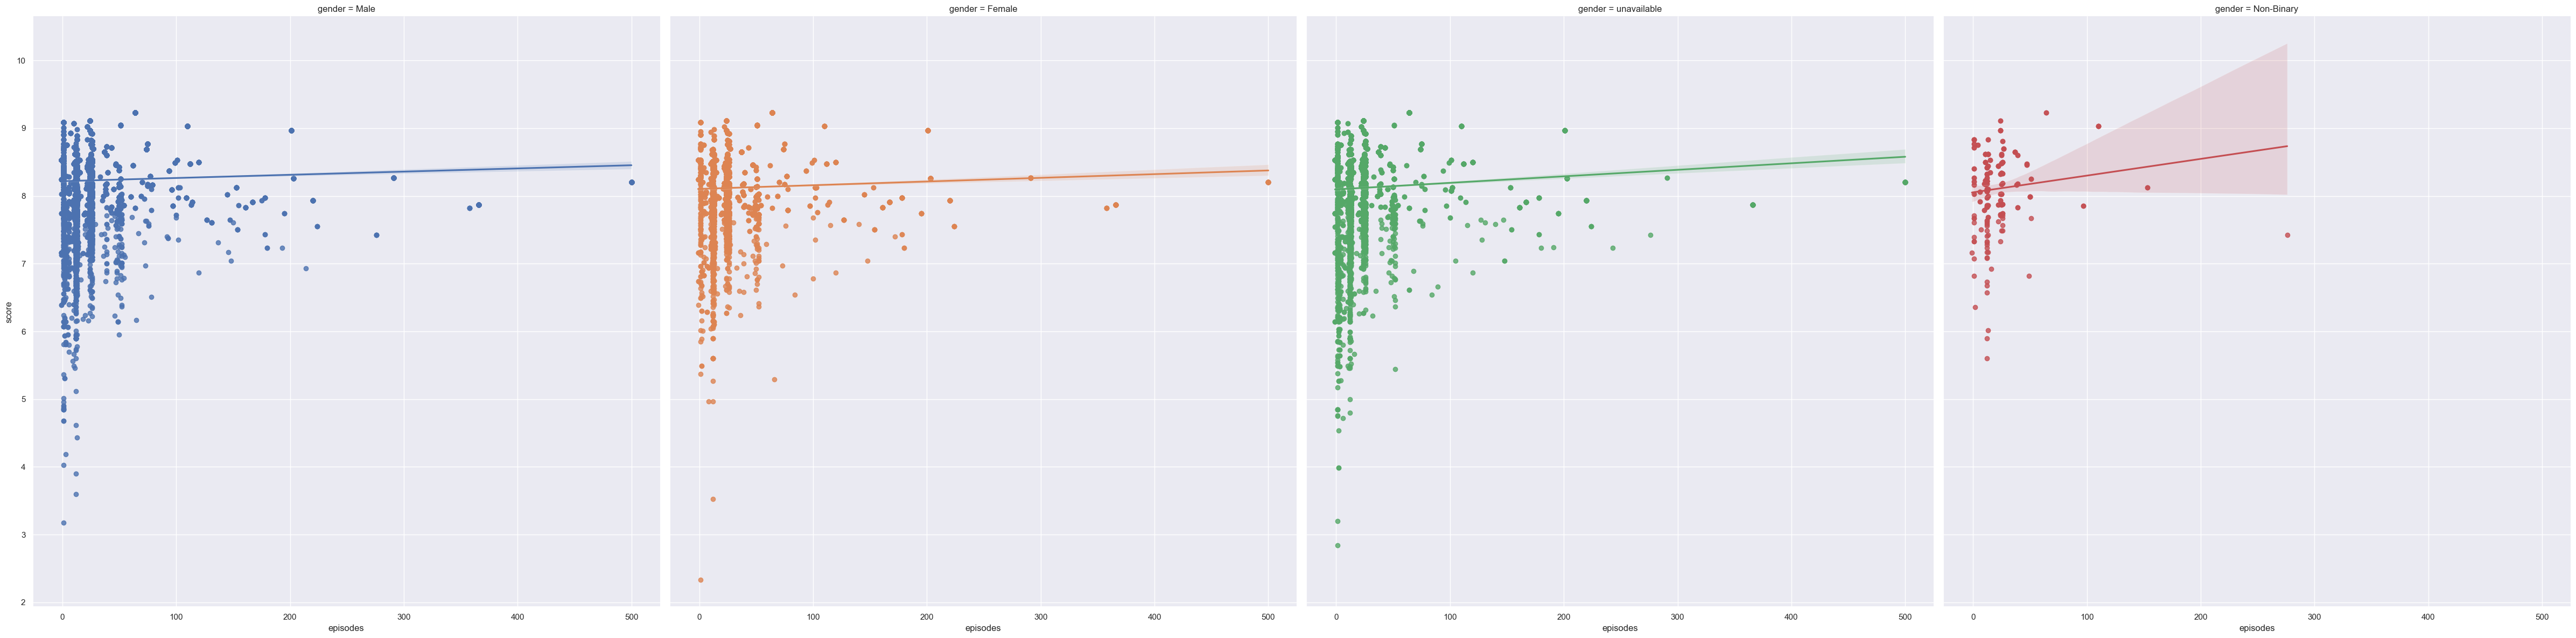

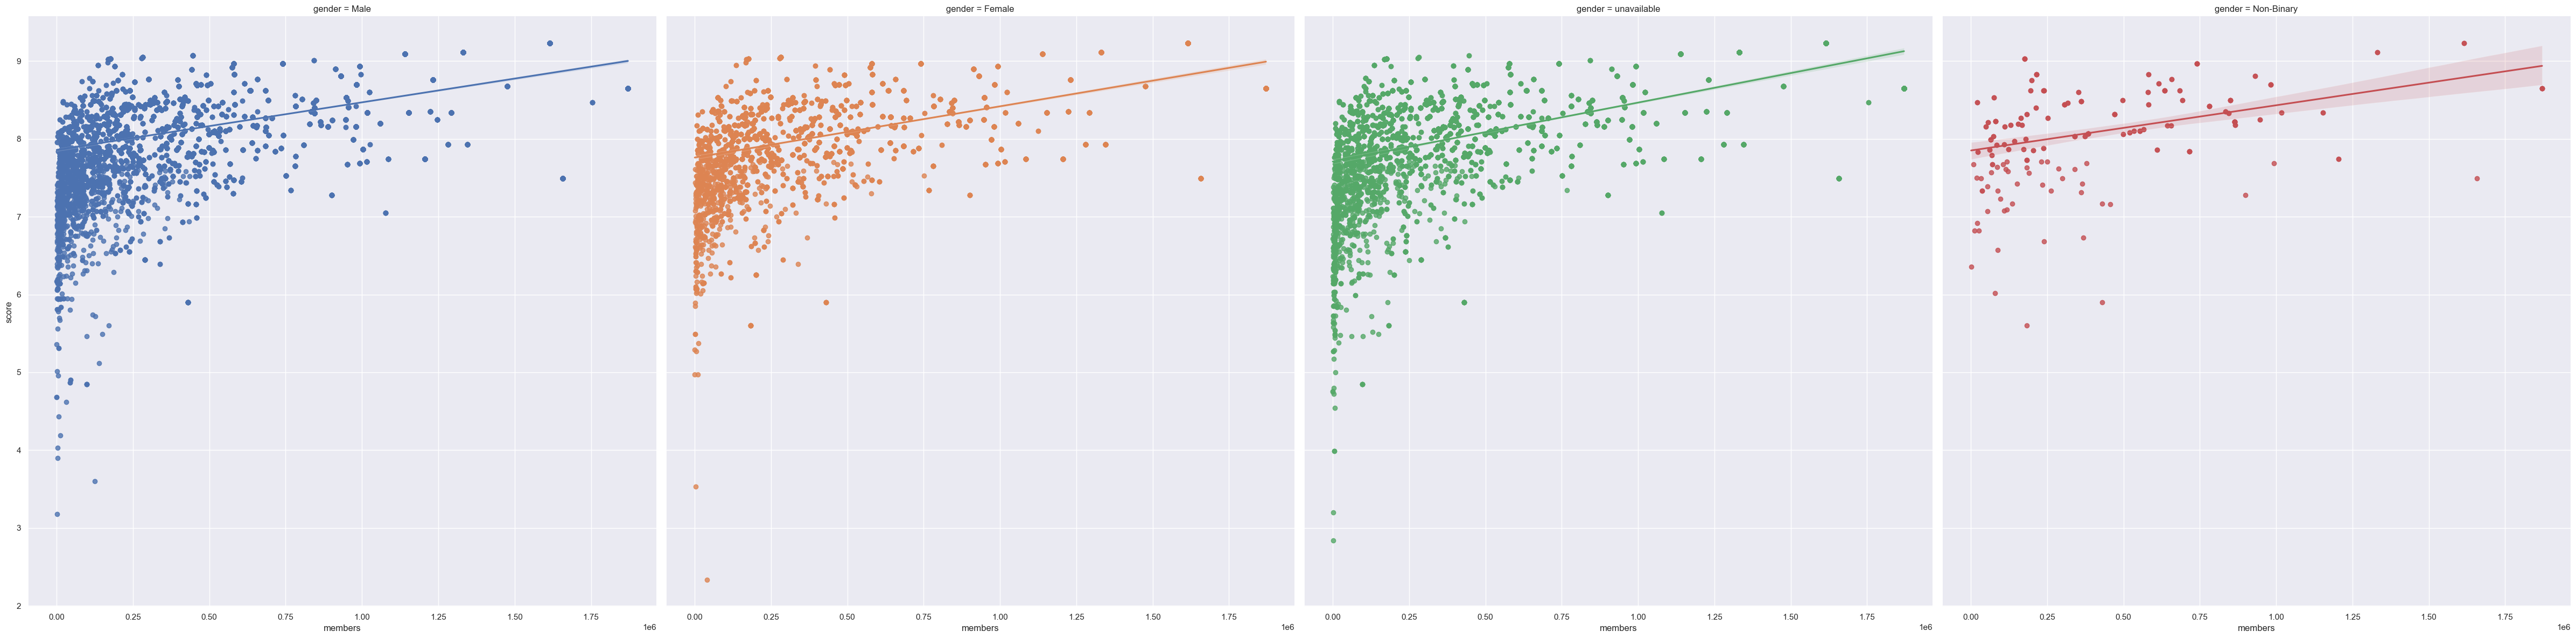

In [74]:
for i in ['ranked','popularity','episodes','members']:
    if i=='ranked':
        sns.lmplot(x=i,y='score',col='gender',hue='gender',height=12,data=merged_rev_df,order=3)
    else:
        sns.lmplot(x=i,y='score',col='gender',hue='gender',height=12,data=merged_rev_df)
plt.show()